In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from me0.data.datasets.index import ME0IndexDataset
from me0.modules.transformer.model import ME0Transformer
from me0.losses import ME0BCELoss

In [2]:
model = ME0Transformer(
    dim_input = 5, # [ieta, layer, strip, cls, bx]
    num_layers = 4,
    dim_model = 128,
    num_heads = 8,
    dim_feedforward = 512,
    activation = "gelu",
    norm_first = True,
    bias = False,
).to_tensor_dict_module()

/Users/yeonju/micromamba/envs/me0segreco-py311/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [3]:
dataset = ME0IndexDataset(
    file='../data/step4_0.h5',
    features={
        'cls': {'min': 1, 'max': 384},
        'bx': {'min': -3, 'max': 3},
    },
)

processing 35430 events:   0%|                                                                                                                           | 1/35430 [00:01<19:03:56,  1.94s/it]


In [4]:
n_train = 10000
n_val = 256

train_loader = DataLoader(dataset[:n_train], collate_fn=dataset.collate, shuffle=True, drop_last=True, batch_size=128)
val_loader = DataLoader(dataset[n_train:n_train+n_val], collate_fn=dataset.collate, shuffle=False, drop_last=True, batch_size=128)

In [5]:
batch = next(iter(train_loader))
batch

TensorDict(
    fields={
        data_mask: Tensor(shape=torch.Size([128, 167]), device=cpu, dtype=torch.bool, is_shared=False),
        eta: Tensor(shape=torch.Size([128, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        indices: Tensor(shape=torch.Size([128, 167, 3]), device=cpu, dtype=torch.int32, is_shared=False),
        input: Tensor(shape=torch.Size([128, 167, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        muon_mask: Tensor(shape=torch.Size([128, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        phi: Tensor(shape=torch.Size([128, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        pt: Tensor(shape=torch.Size([128, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        target: Tensor(shape=torch.Size([128, 167]), device=cpu, dtype=torch.int32, is_shared=False)},
    batch_size=torch.Size([128]),
    device=None,
    is_shared=False)

In [6]:
out = model(batch)
out

TensorDict(
    fields={
        data_mask: Tensor(shape=torch.Size([128, 167]), device=cpu, dtype=torch.bool, is_shared=False),
        eta: Tensor(shape=torch.Size([128, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        indices: Tensor(shape=torch.Size([128, 167, 3]), device=cpu, dtype=torch.int32, is_shared=False),
        input: Tensor(shape=torch.Size([128, 167, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        logits: Tensor(shape=torch.Size([128, 167]), device=cpu, dtype=torch.float32, is_shared=False),
        muon_mask: Tensor(shape=torch.Size([128, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        phi: Tensor(shape=torch.Size([128, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        preds: Tensor(shape=torch.Size([128, 167]), device=cpu, dtype=torch.float32, is_shared=False),
        pt: Tensor(shape=torch.Size([128, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        target: Tensor(shape=torch.Size([128, 167]), d

In [7]:
pad_mask = batch['data_mask'].logical_not()

(out['preds'] == torch.sigmoid(out['logits']).masked_fill(pad_mask, 0.)).all(dim=1)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

In [8]:
num_pos = 0
num_neg = 0
for batch in tqdm(train_loader):
    neg, pos = torch.bincount(batch['target'][batch['data_mask']])
    num_pos += pos
    num_neg += neg

pos_weight = num_neg / num_pos
print(f"{pos_weight=}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:10<00:00,  7.34it/s]

pos_weight=tensor(74.7732)


In [9]:
loss_fn = ME0BCELoss(pos_weight=pos_weight).to_tensor_dict_module()

loss = loss_fn(out)['loss']
loss.backward()
print(f"{loss=}")

loss=tensor(1.1910, grad_fn=<DivBackward0>)


In [10]:
optim = torch.optim.AdamW(model.parameters(), lr=0.001)

out_df = pd.DataFrame(columns=['epoch', 'step', 'train_loss', 'val_loss'])

num_epoch = 5
step = 0

for epoch in range(num_epoch+1):
    # validation
    if epoch == 0:
        with torch.inference_mode():
            for batch in tqdm(val_loader):
                out = model(batch)
                loss = loss = loss_fn(out)['loss'].item()
                out_df.loc[len(out_df)] = [epoch, step, None, loss]
        print(f"""
        Epoch {epoch}/{num_epoch}
            val_loss: {out_df[(out_df['epoch'] == epoch)]['val_loss'].dropna().mean()}
        """)            
        continue
    for batch in tqdm(train_loader):
        optim.zero_grad()
        out = model(batch)
        loss = loss_fn(out)['loss']
        loss.backward()
        optim.step()
        out_df.loc[len(out_df)] = [epoch, step, loss.item(), None]
        step += 1
        
    with torch.inference_mode():
        loss = 0
        for batch in tqdm(val_loader):
            out = model(batch)
            loss += loss_fn(out)['loss'].item()
        out_df.loc[len(out_df)] = [epoch, step, None, loss/len(val_loader)]
    
    print(f"""
    Epoch {epoch}/{num_epoch}
        train_loss: {out_df[(out_df['epoch'] == epoch)]['train_loss'].dropna().mean()}
        val_loss: {out_df[(out_df['epoch'] == epoch)]['val_loss'].dropna().mean()}
    """) 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]



        Epoch 0/5
            val_loss: 1.4807820916175842
        


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.00it/s]



    Epoch 1/5
        train_loss: 1.2364776126849346
        val_loss: 0.5117098093032837
    


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]



    Epoch 2/5
        train_loss: 0.47026693324248
        val_loss: 0.5194476246833801
    


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/it]



    Epoch 3/5
        train_loss: 0.4618161618709564
        val_loss: 0.5170683562755585
    


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]



    Epoch 4/5
        train_loss: 0.4997024818872794
        val_loss: 0.8994899094104767
    


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]


    Epoch 5/5
        train_loss: 0.4770318789359851
        val_loss: 0.4640926569700241
    


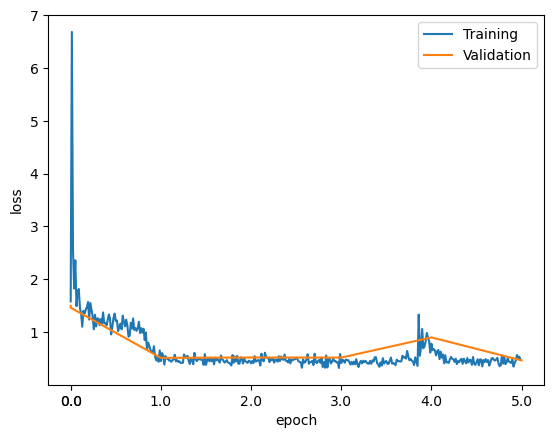

In [11]:
plt.plot(out_df[out_df['train_loss'].notna()]['step'], out_df['train_loss'].dropna(), label='Training')
plt.plot(out_df[out_df['val_loss'].notna()]['step'], out_df['val_loss'].dropna(), label='Validation')
plt.xticks(ticks=out_df[out_df['val_loss'].notna()]['step'], labels=out_df[out_df['val_loss'].notna()]['epoch'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()